In [18]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import cv2
import os

import matplotlib.patches as patches
from scipy import signal, ndimage, misc # for rotate
from skimage import transform # for shear, image pyramid
from sklearn.preprocessing import normalize

In [19]:
IMG_SRC = "given-files/img.png"
TEMPLATE_SRC = "given-files/denticle.png"

RESULTS_DIR = "results/"

In [20]:
img_rgb = cv2.imread(IMG_SRC)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
W, H = img_gray.shape[::-1]
print("Image shape:    ", W, H)


template = cv2.imread(TEMPLATE_SRC, 0) # 0 --> indicated gray image read
w, h = template.shape[::-1] 
print("Template shape: ", w, h)

Image shape:     340 406
Template shape:  242 256


Text(0.5, 1.0, 'Template')

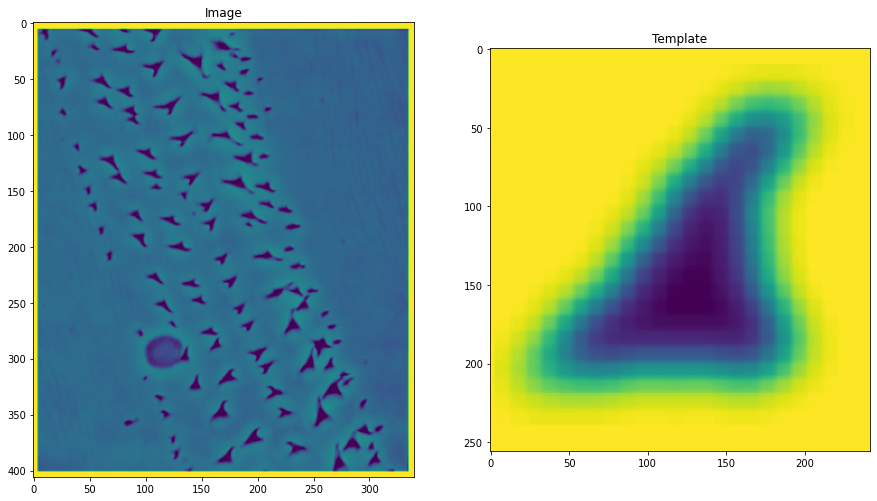

In [21]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_gray)
axs[0].set_title('Image')
axs[1].imshow(template)
axs[1].set_title('Template')

(-0.006099056683018856,
 0.010177096833679487,
 -0.00993769478985486,
 0.002841210981839335)

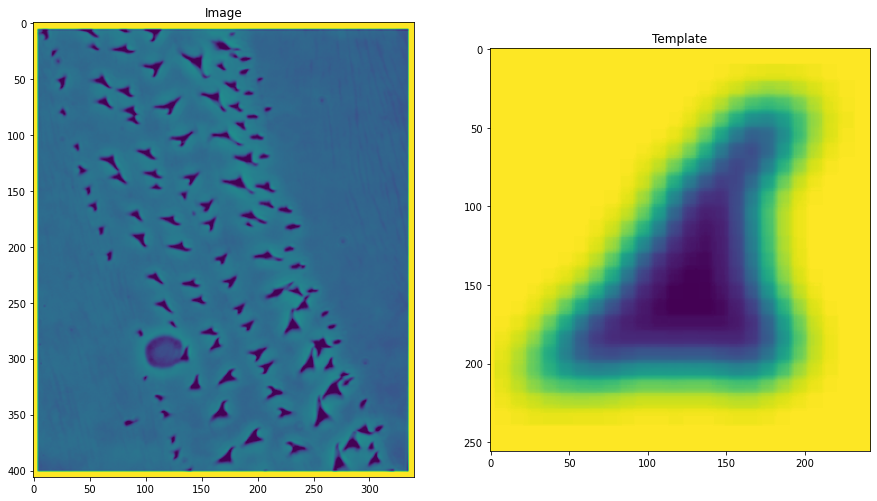

In [22]:
def norm_im(im):
    return (im - np.mean(im)) / np.linalg.norm(im - np.mean(im) + 0.00000001, ord = 'fro')


norm_img_gray = norm_im(img_gray)
norm_template = norm_im(template)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(norm_img_gray)
axs[0].set_title('Image')
axs[1].imshow(norm_template)
axs[1].set_title('Template')

np.min(norm_img_gray), np.max(norm_img_gray), np.min(norm_template), np.max(norm_template)

# Scratch

In [6]:
resized_norm_template = cv2.resize(norm_template, (32, 32))

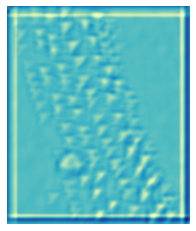

In [10]:
corr_output = signal.correlate(norm_img_gray, resized_norm_template, mode='same')

plt.rcParams["figure.figsize"] = [4, 4]
plt.imshow(corr_output, cmap = 'YlGnBu_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('cross_cor_new_template.png', bbox_inches = 'tight')
plt.show()

-0.01053182921744185 0.009201727172049508
-1.0 1.0
438 438


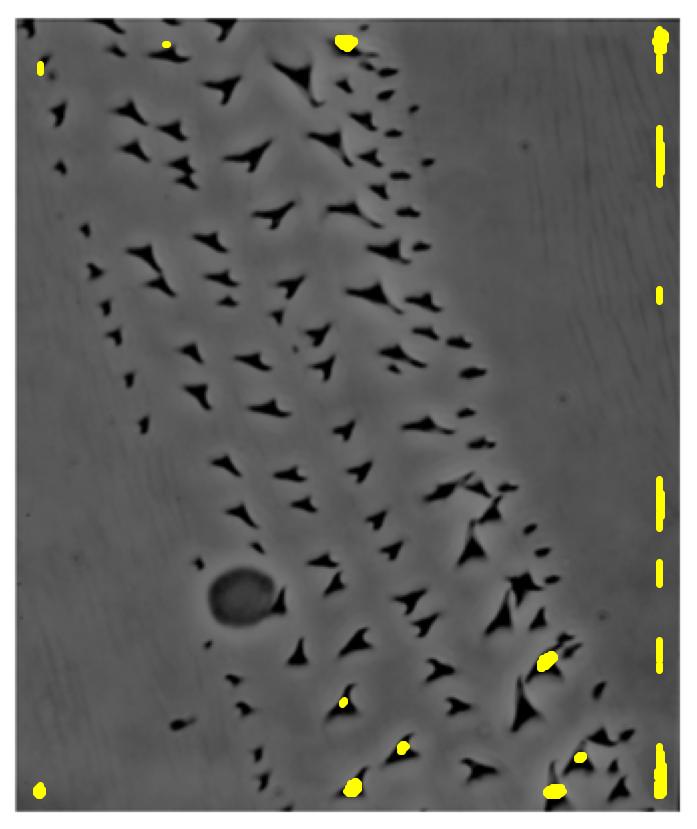

In [13]:
print( np.min(corr_output), np.max(corr_output) )

corr_output_max_norm = normalize(corr_output, norm='max')

print( np.min(corr_output_max_norm), np.max(corr_output_max_norm) )

# Specify a threshold 
threshold = 0.8
  
# Store the coordinates of matched area in a numpy array 
loc = np.where( corr_output_max_norm >= threshold)  
print(len(loc[0]), len(loc[1]))
  
plt.rcParams["figure.figsize"] = [15, 15]


# Draw a rectangle around the matched region. 
for pt in zip(*loc[::-1]): 
    # cv2.rectangle(img_gray, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2) 
    plt.scatter(pt[0], pt[1], c = 'yellow') 


# plt.imshow(img_rgb)
plt.imshow(img_rgb, cmap = 'gray_r')
# plt.scatter(max_points_x, max_points_y, c = 'yellow') 
plt.axis("off")
plt.grid(True)
# plt.savefig('background_points_conv_2000.png', bbox_inches = 'tight')
plt.show()

# Multi-size detection

Image shape:     512 512
Template shape:  12 12
605 605


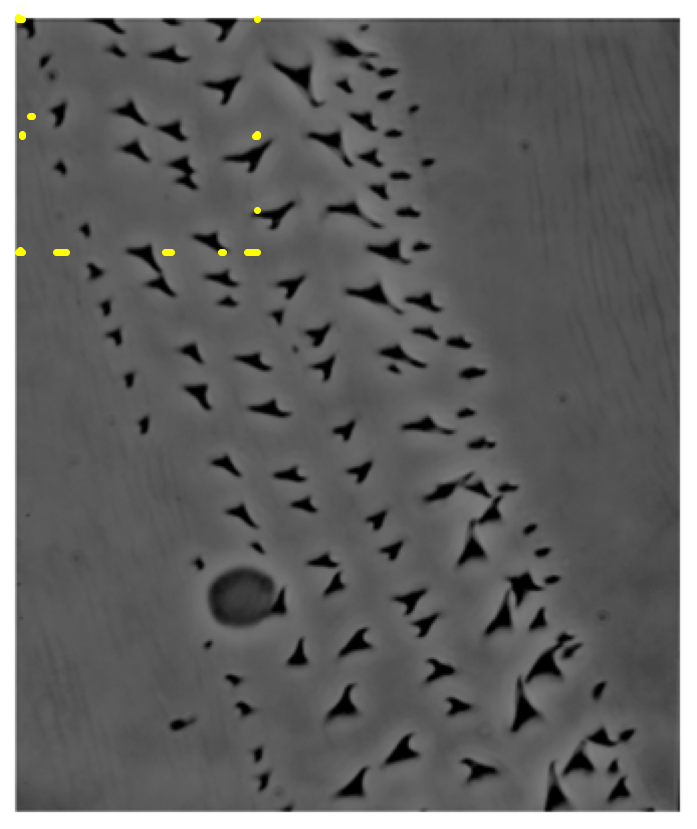

In [25]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import cv2
import os

import matplotlib.patches as patches
from scipy import signal, ndimage, misc # for rotate
from skimage import transform # for shear, image pyramid
from sklearn.preprocessing import normalize
import scipy

# =========================================================================================================


IMG_SRC = "given-files/img.png"
TEMPLATE_SRC = "given-files/denticle.png"

RESULTS_DIR = "results/"

# =========================================================================================================



img_rgb = cv2.imread(IMG_SRC)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
img_gray = cv2.resize(img_gray, (512, 512))
W, H = img_gray.shape[::-1]
print("Image shape:    ", W, H)


template = cv2.imread(TEMPLATE_SRC, 0) # 0 --> indicated gray image read
template = cv2.resize(template, (12, 12))
w, h = template.shape[::-1] 
print("Template shape: ", w, h)


# =========================================================================================================


def norm_im(im):
    return (im - np.mean(im)) / np.linalg.norm(im - np.mean(im) + 0.00000001, ord = 'fro')


norm_template = norm_im(template)
# print( np.min(norm_img_gray), np.max(norm_img_gray), np.min(norm_template), np.max(norm_template) )


# =========================================================================================================

# max_height = template.shape[1] # = 256

threshold = 0.8


all_loc_list = []
for scale in np.linspace(128, 512, 10)[::-1]:
    int_scale = int(scale)
    resized_img_gray = cv2.resize(img_gray, (int_scale, int_scale))
    
    norm_resized_img_gray = norm_im(resized_img_gray)
    
    for rotate_ang in [0, 90, 180, 270]:
        # rotated_norm_template = misc.imrotate(norm_template, angle = rotate_ang)
        rotated_norm_template = scipy.ndimage.interpolation.rotate(norm_template, angle = rotate_ang)
    
    
        corr_output = signal.convolve(norm_resized_img_gray, rotated_norm_template, mode = 'same')
        # corr_output = signal.correlate(norm_resized_img_gray, norm_template, mode='same')
        # corr_output = signal.correlate(norm_template, norm_resized_img_gray, mode='same')
    
        corr_output_max_norm = normalize(corr_output, norm='max')
    
        loc = np.where( corr_output_max_norm >= threshold)
        all_loc_list.extend(loc)
    
    
print(len(all_loc_list[0]), len(all_loc_list[1]))
plt.rcParams["figure.figsize"] = [15, 15]

for pt in zip(*all_loc_list[::-1]): 
    # cv2.rectangle(img_gray, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2) 
    plt.scatter(pt[0], pt[1], c = 'yellow') 
    # plt.scatter(pt[1], pt[0], c = 'yellow') 


plt.imshow(img_rgb)
plt.axis("off")
plt.grid(True)
plt.show()

Image shape:     512 512
Template shape:  40 40
0.0 1.0
518 518


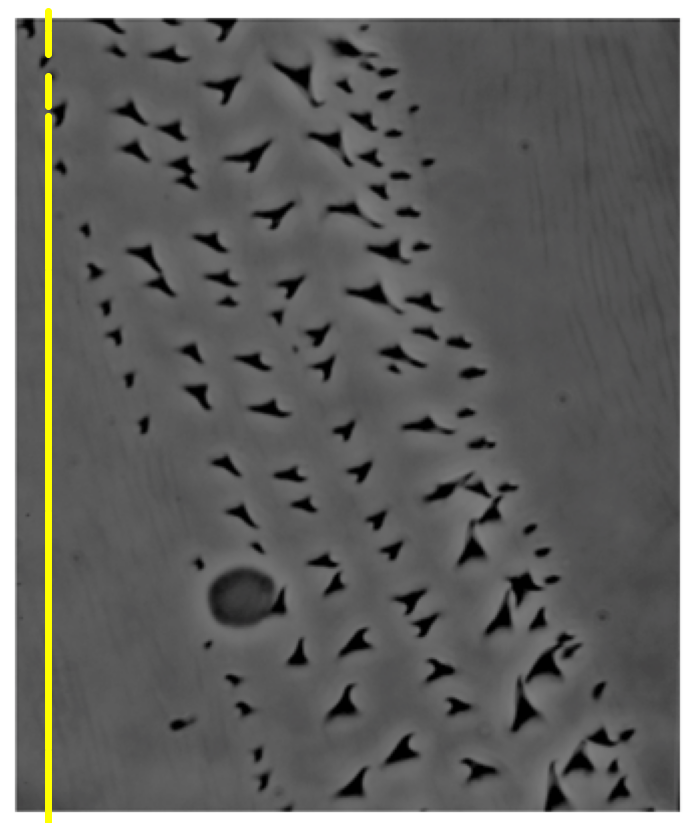

In [58]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import cv2
import os

import matplotlib.patches as patches
from scipy import signal, ndimage, misc # for rotate
from skimage import transform # for shear, image pyramid
from sklearn.preprocessing import normalize
import scipy
# =========================================================================================================

IMG_SRC = "given-files/img.png"
TEMPLATE_SRC = "given-files/denticle.png"
RESULTS_DIR = "results/"
# =========================================================================================================

img_rgb = cv2.imread(IMG_SRC)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
img_gray = cv2.resize(img_gray, (512, 512))
W, H = img_gray.shape[::-1]
print("Image shape:    ", W, H)

template = cv2.imread(TEMPLATE_SRC, 0) # 0 --> indicated gray image read
template = cv2.resize(template, (40, 40))
w, h = template.shape[::-1] 
print("Template shape: ", w, h)

# plt.imshow(template)
# plt.axis("off")
# plt.grid(True)
# plt.show()
# =========================================================================================================

# def norm_im(im):
#     return (im - np.mean(im)) / np.linalg.norm(im - np.mean(im) + 0.00000001, ord = 'fro')

# norm_template = norm_im(template)
norm_template = template / 255.0
print( np.min(norm_template), np.max(norm_template) )
# print( np.min(norm_img_gray), np.max(norm_img_gray), np.min(norm_template), np.max(norm_template) )
# =========================================================================================================

# max_height = template.shape[1] # = 256
threshold = 0.999

all_loc_x_list = []
all_loc_y_list = []
for scale in np.linspace(128, 512, 10)[::-1]:
    int_scale = int(scale)
    resized_img_gray = cv2.resize(img_gray, (int_scale, int_scale))
    
    # norm_resized_img_gray = norm_im(resized_img_gray)
    norm_resized_img_gray = resized_img_gray / 255.0
    
    for rotate_ang in [0, 90, 180, 270]:
        # rotated_norm_template = misc.imrotate(norm_template, angle = rotate_ang)
        rotated_norm_template = scipy.ndimage.interpolation.rotate(norm_template, angle = rotate_ang)
    
    
        corr_output = signal.convolve(norm_resized_img_gray, rotated_norm_template, mode = 'same')
        # corr_output = signal.correlate(norm_resized_img_gray, rotated_norm_template, mode='same')
        # corr_output = signal.correlate(norm_template, norm_resized_img_gray, mode='same')
    
        corr_output_max_norm = normalize(corr_output, norm='max')
        # print( "corr_output : ", np.min(corr_output_max_norm), np.max(corr_output_max_norm) )
    
        loc = np.where( corr_output_max_norm >= threshold)
        all_loc_x_list.extend(loc[0])
        all_loc_y_list.extend(loc[1])
#         print(len( loc) )
#         print(len( loc[0]) )
#         print(len( loc[1]) )
#         all_loc_list.extend(loc)
        
        break
    break
    
all_loc_list = [all_loc_x_list, all_loc_y_list]
    
print(len(all_loc_list[0]), len(all_loc_list[1]))
plt.rcParams["figure.figsize"] = [15, 15]

for pt in zip(*all_loc_list[::-1]): 
#     print( pt )
#     cv2.rectangle(main_image, (x_start, y_start), (x_end, y_end), (153, 22, 0), 5)
#     cv2.rectangle(img_gray, pt, (pt[0] + 4, pt[1] + 4), (0,255,255), 2) 
#     cv2.rectangle(img_gray, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2) 
    plt.scatter(pt[0], pt[1], c = 'yellow') 
    # plt.scatter(pt[1], pt[0], c = 'yellow') 


# cv2.imshow(img_gray)
plt.imshow(img_rgb)
plt.axis("off")
plt.grid(True)
plt.show()

In [26]:
# import pydicom as dicom
# import matplotlib.pylab as plt
# import numpy as np
# import cv2
# import os

# import matplotlib.patches as patches
# from scipy import signal, ndimage, misc # for rotate
# from skimage import transform # for shear, image pyramid
# from sklearn.preprocessing import normalize


# # =========================================================================================================

# IMG_SRC = "given-files/img.png"
# TEMPLATE_SRC = "given-files/denticle.png"

# RESULTS_DIR = "results/"

# # =========================================================================================================



# img_rgb = cv2.imread(IMG_SRC)
# img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
# W, H = img_gray.shape[::-1]
# print("Image shape:    ", W, H)


# template = cv2.imread(TEMPLATE_SRC, 0) # 0 --> indicated gray image read
# w, h = template.shape[::-1] 
# print("Template shape: ", w, h)


# # =========================================================================================================


# def norm_im(im):
#     return (im - np.mean(im)) / np.linalg.norm(im - np.mean(im) + 0.00000001, ord = 'fro')


# norm_img_gray = norm_im(img_gray)
# norm_template = norm_im(template)

# print( np.min(norm_img_gray), np.max(norm_img_gray), np.min(norm_template), np.max(norm_template) )


# # =========================================================================================================



# max_height = template.shape[1] # = 256

# threshold = 0.95

# square_norm_template = cv2.resize(norm_template, (256, 256))


# all_loc_list = []
# for scale in np.linspace(9, 256, 20)[::-1]:
#     int_scale = int(scale)
#     resized_sq_norm_template = cv2.resize(square_norm_template, (int_scale, int_scale))
    
#     # corr_output = signal.correlate(norm_img_gray, resized_sq_norm_template, mode='same')
#     corr_output = signal.convolve(norm_img_gray, resized_sq_norm_template, mode = 'same')
    
#     corr_output_max_norm = normalize(corr_output, norm='max')
    
#     loc = np.where( corr_output_max_norm >= threshold)
#     all_loc_list.extend(loc)
    
    
# print(len(all_loc_list[0]), len(all_loc_list[1]))
# plt.rcParams["figure.figsize"] = [8, 8]

# for pt in zip(*all_loc_list[::-1]): 
#     # cv2.rectangle(img_gray, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2) 
#     plt.scatter(pt[0], pt[1], c = 'yellow') 


# plt.imshow(img_rgb)
# plt.axis("off")
# plt.grid(True)
# # plt.savefig('background_points_conv_2000.png', bbox_inches = 'tight')
# plt.show()

In [27]:
# import pydicom as dicom
# import matplotlib.pylab as plt
# import numpy as np
# import cv2
# import os

# import matplotlib.patches as patches
# from scipy import signal, ndimage, misc # for rotate
# from skimage import transform # for shear, image pyramid
# from sklearn.preprocessing import normalize
# from pyimagesearch.nms import non_max_suppression_slow

# # =========================================================================================================

# IMG_SRC = "given-files/img.png"
# TEMPLATE_SRC = "given-files/denticle.png"

# RESULTS_DIR = "results/"

# # =========================================================================================================

# img_rgb = cv2.imread(IMG_SRC)
# img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
# W, H = img_gray.shape[::-1]
# print("Image shape:    ", W, H)

# template = cv2.imread(TEMPLATE_SRC, 0) # 0 --> indicated gray image read
# w, h = template.shape[::-1] 
# print("Template shape: ", w, h)

# # =========================================================================================================
# def norm_im(im):
#     return (im - np.mean(im)) / np.linalg.norm(im - np.mean(im) + 0.00000001, ord = 'fro')

# norm_img_gray = norm_im(img_gray)
# norm_template = norm_im(template)

# print( np.min(norm_img_gray), np.max(norm_img_gray), np.min(norm_template), np.max(norm_template) )

# # =========================================================================================================

# max_height = template.shape[1] # = 256

# threshold = 0.95

# square_norm_template = cv2.resize(norm_template, (256, 256))


# all_loc_list = []
# for scale in np.linspace(9, 256, 20)[::-1]:
#     int_scale = int(scale)
#     resized_sq_norm_template = cv2.resize(square_norm_template, (int_scale, int_scale))
    
#     corr_output = signal.correlate(norm_img_gray, resized_sq_norm_template, mode='same')
    
#     corr_output_max_norm = normalize(corr_output, norm='max')
    
#     loc = np.where( corr_output_max_norm >= threshold)
#     all_loc_list.extend(loc)
    
    
# print(len(all_loc_list[0]), len(all_loc_list[1]))
# plt.rcParams["figure.figsize"] = [8, 8]

# for pt in zip(*all_loc_list[::-1]): 
#     # cv2.rectangle(img_gray, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2) 
#     plt.scatter(pt[0], pt[1], c = 'yellow') 


# plt.imshow(img_rgb)
# plt.axis("off")
# plt.grid(True)
# # plt.savefig('background_points_conv_2000.png', bbox_inches = 'tight')
# plt.show()